In [1]:
import cvxpy as cp
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from os import path
from linear_opt.lin_metabolism import MW_C_ATOM
from linear_opt.lin_metabolism import LinearMetabolicModel
from linear_opt.lin_metabolism import GrowthRateOptParams
from linear_opt.lin_metabolism import SingleSubstrateMMRateLaw
from linear_opt.lin_metabolism import MultiSubstrateMMRateLaw
from linear_opt.lin_metabolism import ZerothOrderRateLaw
from matplotlib.ticker import LogFormatter 

from SALib import ProblemSpec

# Approximate concentrations and ratios for plotting
# Based on Bennett et al. 2009 measurements in E. coli
DEFAULT_ATP = 1.4e-6
DEFAULT_NADH = 1.2e-7
DEFAULT_RE = 10
DEFAULT_RA = 0.3

In [2]:
model_dir = '../models/linear/respiration/'
m_fname = path.join(model_dir, 'glucose_resp_molecular_props.csv')
S_fname = path.join(model_dir, 'glucose_resp_stoich_matrix.csv')
lam = LinearMetabolicModel.FromFiles(m_fname, S_fname)
#lam.print_model()

In [4]:
# Concentrations are typically ~1 mM, converting to mol/gCDW
# If the density rho ≈ 1000 g/L, 1/rho ≈ 1e-3 L/g = 1 mL/g so... 
# 1e-3 mol/L x 1e-3 L/g x 0.3 gDW/g x 2 gDW/gCDW = 1.5e-7 mol/gCDW
params = GrowthRateOptParams(min_phi_O=0.4, 
                             #rate_law=ZerothOrderRateLaw(),
                             do_dilution=True,
                             rate_law=SingleSubstrateMMRateLaw(),
                             fixed_ATP=1e-6, fixed_NADH=1e-6,
                             fixed_re=10, fixed_ra=0.3)
p = lam.max_growth_rate_problem(params)
p.solve(verbose=True)

#lam.solution_as_dict(p)

                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Aug 23 11:28:08 AM: Your problem has 5 variables, 3 constraints, and 23 parameters.
(CVXPY) Aug 23 11:28:08 AM: It is compliant with the following grammars: DCP, DQCP


(CVXPY) Aug 23 11:28:08 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 23 11:28:08 AM: Compiling problem (target solver=ECOS).
(CVXPY) Aug 23 11:28:08 AM: Reduction chain: EvalParams -> FlipObjective -> Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> ECOS
(CVXPY) Aug 23 11:28:08 AM: Applying reduction EvalParams
(CVXPY) Aug 23 11:28:08 AM: Applying reduction FlipObjective
(CVXPY) Aug 23 11:28:08 AM: Applying reduction Dcp2Cone
(CVXPY) Aug 23 11:28:08 AM: Applying reduction CvxAttr2Constr
(CVXPY) Aug 23 11:28:08 AM: Applying reduction ConeMatrixStuffing
(CVXPY) Aug 23 11:28:08 AM: Applying reduction ECOS
(CVXPY) Aug 23 11:28:08 AM: Finished problem compilation (took 1.210e-01 se

1.4583550081780847

In [5]:
# Do a quick run of the model to make sure it is feasible
params = GrowthRateOptParams(maintenance_cost=1e-6, phi_O=0.4)
opt, problem = lam.maximize_growth_rate(params)
opt

2.2870588142242774

In [5]:
concs = np.logspace(-7, -1, 50)
ATPgrid, NADHgrid = np.meshgrid(concs, concs)
lambda_grid = np.zeros_like(ATPgrid)

for i, ATP in enumerate(concs):
    for j, NADH in enumerate(concs):
        params = GrowthRateOptParams(min_phi_O=0.4, do_dilution=True,
                                     fixed_ATP=ATP, fixed_NADH=NADH)
        opt, _ = lam.maximize_growth_rate(params)
        lambda_grid[i, j] = opt

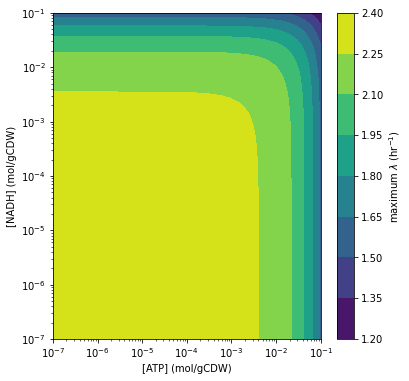

In [6]:
plt.figure(figsize=(6, 6))
plt.xscale('log')
plt.yscale('log')
plt.contourf(ATPgrid, NADHgrid, lambda_grid, cmap='viridis')
plt.xlabel('[ATP] (mol/gCDW)')
plt.ylabel('[NADH] (mol/gCDW)')
cb = plt.colorbar(label=r'maximum $\lambda$ (hr$^{-1}$)')
plt.show()

In [7]:
# Same as above, first order kinetics
concs = np.logspace(-8, -1, 50)
ATPgrid, NADHgrid = np.meshgrid(concs, concs)
lambda_grid = np.zeros_like(ATPgrid)

for i, ATP in enumerate(concs):
    for j, NADH in enumerate(concs):
        rl = MultiSubstrateMMRateLaw()
        params = GrowthRateOptParams(min_phi_O=0.4, do_dilution=True,
                                     fixed_ATP=ATP, fixed_NADH=NADH,
                                     fixed_re=10, fixed_ra=0.3,
                                     rate_law=rl)
        opt = np.NaN
        try:
            opt, _ = lam.maximize_growth_rate(params)
        except:
            # Optimal solution not found
            pass
        
        lambda_grid[i, j] = opt

In [8]:
lambda_grid.max()

2.27728617673327

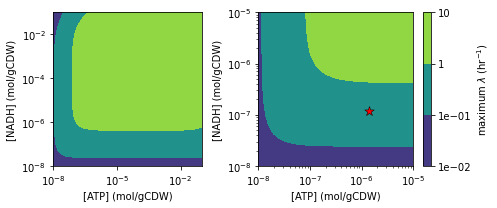

In [19]:
fig, axs = plt.subplots(figsize=(7, 3), ncols=2, width_ratios=[1, 1.3])

plt.sca(axs[0])
plt.xscale('log')
plt.yscale('log')
plt.contourf(ATPgrid, NADHgrid, lambda_grid, cmap='viridis', norm=LogNorm())
plt.xlabel('[ATP] (mol/gCDW)')
plt.ylabel('[NADH] (mol/gCDW)')

plt.sca(axs[1])
# plot zoomed in on the range of ATP and NADH concentrations we care about
# which are 1e-8 to 1e-5 for both 
plt.xscale('log')
plt.yscale('log')
plt.contourf(ATPgrid, NADHgrid, lambda_grid, cmap='viridis', norm=LogNorm())
plt.xlabel('[ATP] (mol/gCDW)')
plt.ylabel('[NADH] (mol/gCDW)')
plt.xlim(1e-8, 1e-5)
plt.ylim(1e-8, 1e-5)
formatter = LogFormatter(10, labelOnlyBase=False)
cb = plt.colorbar(label=r'maximum $\lambda$ (hr$^{-1}$)', format=formatter)

# put a * at the Bennet concentrations of ATP ≈ 1.4e-6 (9.6 mM) and NADH ≈ 1.2e-7 (83 uM)
plt.scatter(DEFAULT_ATP, DEFAULT_NADH, marker='*', color='red', edgecolor='k', lw=0.5, s=100)

plt.tight_layout()
plt.show()

In [6]:
# Here is a model that has no homeostasis (phi_H <= 0),
# no maintenance (ATP_maint = 0), but can alter biomass
# composition through phi_O. We set a maximum lambda
# so that we can run the model over a range of lambda values.
params = GrowthRateOptParams(min_phi_O=0.4, do_dilution=True, 
                             max_lambda_hr=0.1, max_phi_H=0,
                             fixed_ATP=DEFAULT_ATP, fixed_NADH=DEFAULT_NADH,
                             fixed_re=DEFAULT_RE, fixed_ra=DEFAULT_RA)
                                
p = lam.max_growth_rate_problem(params)
lambdas = np.arange(0.1, 1.501, 0.01)
results = []

for lam_val in lambdas:
    p.param_dict['max_lambda_hr'].value = lam_val
    res = p.solve()
    d = lam.solution_as_dict(p)
    d.update(lam.model_as_dict())
    results.append(d)

phi_df = pd.DataFrame(results)
phi_df['max_lambda_hr'] = lambdas
phi_df.head()

,lambda_hr,maint,max_lambda_hr,phi_O,min_phi_O,oxidation_gamma,oxidation_phi,oxidation_flux,reduction_gamma,reduction_phi,...,ATP_homeostasis_m_kDa,ZCB,ZCorg,ZCprod,S1,S2,S3,S4,S5,S6
0,0.10,0.0,0.10,0.973765,0.4,0.00005,0.001543,1.543311e-07,0.0002,0.001543,...,2000.0,0.0,0.0,4.0,2.0,0.5,0.5,1.0,0.3,0.0
1,0.11,0.0,0.11,0.971142,0.4,0.00005,0.001698,1.697642e-07,0.0002,0.001698,...,2000.0,0.0,0.0,4.0,2.0,0.5,0.5,1.0,0.3,0.0
2,0.12,0.0,0.12,0.968518,0.4,0.00005,0.001852,1.851973e-07,0.0002,0.001852,...,2000.0,0.0,0.0,4.0,2.0,0.5,0.5,1.0,0.3,0.0
3,0.13,0.0,0.13,0.965895,0.4,0.00005,0.002006,2.006304e-07,0.0002,0.002006,...,2000.0,0.0,0.0,4.0,2.0,0.5,0.5,1.0,0.3,0.0
4,0.14,0.0,0.14,0.963271,0.4,0.00005,0.002161,2.160636e-07,0.0002,0.002161,...,2000.0,0.0,0.0,4.0,2.0,0.5,0.5,1.0,0.3,0.0


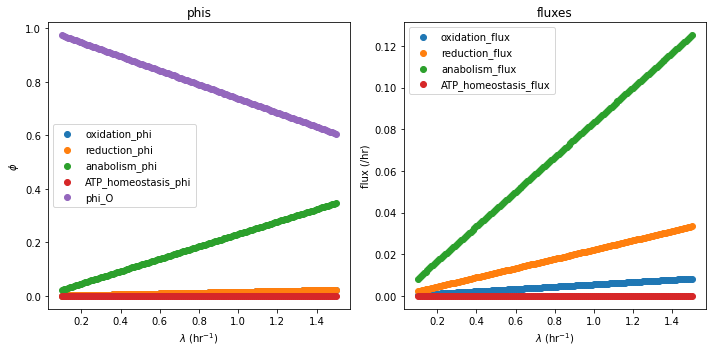

In [7]:
# Notice that phi_O increases as lambda decreases
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

plt.sca(axs[0])

x = phi_df['lambda_hr']
phi_cols = [c for c in phi_df.columns if c.endswith('phi')] + ['phi_O']
for col in phi_cols:
    plt.scatter(x, phi_df[col], label=col)
plt.title('phis')
plt.xlabel(r'$\lambda$ (hr$^{-1}$)')
plt.ylabel(r'$\phi$')   
plt.legend()

plt.sca(axs[1])
j_cols = [c for c in phi_df.columns if c.endswith('flux')]
for col in j_cols:
    plt.scatter(x, phi_df[col]*3600, label=col)
plt.title('fluxes')
plt.xlabel(r'$\lambda$ (hr$^{-1}$)')
plt.ylabel(r'flux (/hr)')
plt.legend()

plt.tight_layout()
plt.show()


In [13]:
ZCBs = np.arange(-3, 3.01, 0.05)
phi_os = np.arange(0.1, 0.501, 0.2)
homeo_costs = np.logspace(1, 5, 3)
resp_costs = np.logspace(1, 3, 3)
ATP_per_es = [0.25, 0.5, 1, 2]

lmm = LinearMetabolicModel.FromFiles(m_fname, S_fname)
results = []
for z in ZCBs:
    for phi_O in phi_os:
        for homeo_cost in homeo_costs:
            for resp_cost in resp_costs:
                for atp_per_e in ATP_per_es:
                    try:
                        ref_lam = lmm.copy()
                        ref_lam.set_ZCB(z)
                        ref_lam.set_process_mass('reduction', resp_cost)
                        ref_lam.set_process_mass('ATP_homeostasis', homeo_cost)
                        ref_lam.set_ATP_yield('reduction', atp_per_e)

                        params = GrowthRateOptParams(
                            min_phi_O=phi_O, do_dilution=True,
                            fixed_ATP=DEFAULT_ATP, fixed_NADH=DEFAULT_NADH,
                            fixed_re=DEFAULT_RE, fixed_ra=DEFAULT_RA)
                        m, opt_p = ref_lam.maximize_growth_rate(params)

                        if opt_p.status != cp.OPTIMAL:
                            continue
                        
                        d = ref_lam.model_as_dict()
                        d.update(ref_lam.solution_as_dict(opt_p))
                        d['reduction_ATP_per_e'] = atp_per_e
                        results.append(d)
                    except Exception as e:
                        print(e)
                        continue
res_df = pd.DataFrame(results)

/opt/miniconda3/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:178: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)
/opt/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Solver 'ECOS' failed. Try another solver, or solve with verbose=True for more information.
Solver 'ECOS' failed. Try another solver, or solve with verbose=True for more information.


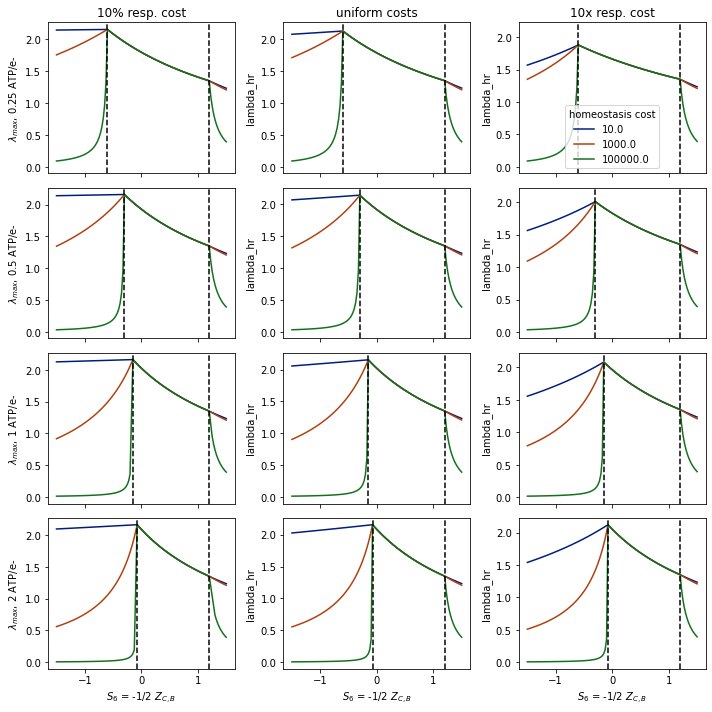

In [16]:
fig, axs = plt.subplots(figsize=(10, 10), nrows=4, ncols=3, sharex=True, sharey='col')

titles = '10% resp. cost,uniform costs,10x resp. cost'.split(',')
for i, a_per_e in enumerate(ATP_per_es):
    for j, resp_cost in enumerate(resp_costs):
        plt.sca(axs[i, j])
        mask = np.logical_and(res_df.reduction_m_kDa == resp_cost, res_df.min_phi_O == phi_os[2])
        mask = np.logical_and(mask, res_df.reduction_ATP_per_e == a_per_e)
        sns.lineplot(data=res_df[mask], x='S6', y='lambda_hr', hue='ATP_homeostasis_m_kDa', palette='dark')
        
        masked = res_df[mask]
        S1 = masked.S1.values[0]
        S2 = masked.S2.values[0]
        S3 = masked.S3.values[0]
        S4 = masked.S4.values[0]
        S5 = masked.S5.values[0]

        # bounds at zero maintenance  
        S6_lb = -S2*S5/S4 
        S6_ub = S1*S5/S3
        plt.axvline(S6_lb, color='k', linestyle='--')
        plt.axvline(S6_ub, color='k', linestyle='--')
        plt.xlabel('$S_6$ = -1/2 $Z_{C,B}$')
        plt.legend().set_visible(False)

        if i == 0:
            plt.title(titles[j])
        
        if j == 0:
            plt.ylabel(r'$\lambda_{{max}}$, {0} ATP/e-'.format(a_per_e))

plt.sca(axs[0,2])
plt.legend(title='homeostasis cost').set_visible(True)

plt.tight_layout()
plt.savefig('../output/lambda_max_vs_S6.png', dpi=300, facecolor='white')
plt.show()

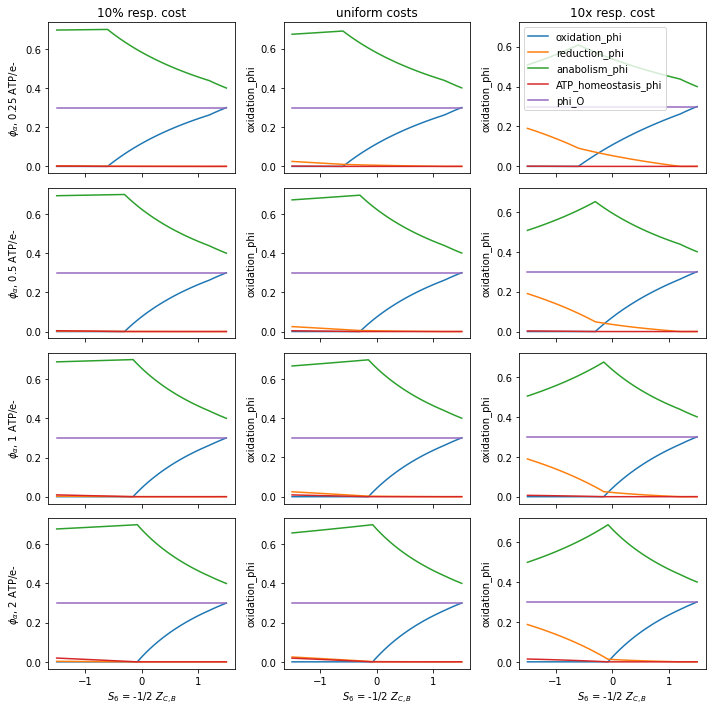

In [17]:
fig, axs = plt.subplots(figsize=(10, 10), nrows=4, ncols=3, sharex=True, sharey='col')
phi_cols = [c for c in res_df.columns if c.endswith('phi')] + ['phi_O']

titles = '10% resp. cost,uniform costs,10x resp. cost'.split(',')
for i, a_per_e in enumerate(ATP_per_es):
    for j, resp_cost in enumerate(resp_costs):
        plt.sca(axs[i, j])
        mask = np.logical_and(res_df.reduction_m_kDa == resp_cost, res_df.min_phi_O == phi_os[1])
        mask = np.logical_and(mask, res_df.reduction_ATP_per_e == a_per_e)
        mask = np.logical_and(mask, res_df.ATP_homeostasis_m_kDa == 10)

        for c in phi_cols:
            sns.lineplot(data=res_df[mask], x='S6', y=c, palette='dark', label=c)
        plt.xlabel('$S_6$ = -1/2 $Z_{C,B}$')
        plt.legend().set_visible(False)

        if i == 0:
            plt.title(titles[j])
        
        if j == 0:
            plt.ylabel(r'$\phi_{{\alpha}}$, {0} ATP/e-'.format(a_per_e))

plt.sca(axs[0,2])
plt.legend().set_visible(True)

plt.tight_layout()
#plt.savefig('../output/lambda_max_vs_S6.png', dpi=300, facecolor='white')
plt.show()

In [18]:
def analytic_gamma(row):
    """Calculates gamma from an analytic solution by Lagrange multipliers."""
    g_ana = row.anabolism_gamma
    g_red = row.reduction_gamma
    g_ox = row.oxidation_gamma
    g_h = row.ATP_homeostasis_gamma
    phi_h = row.ATP_homeostasis_phi
    phi_O = row.phi_O
    b = row.maint
    S1, S2, S3, S4, S5, S6 = row.S1, row.S2, row.S3, row.S4, row.S5, row.S6
    phi_term = (-1 + phi_h + phi_O)
    Sterm = S1*S5 - S3*S6
    num = -g_ana*(S2*g_red*(m + g_h*phi_h + S3*g_ox*phi_term))
    num += -g_ana*(S1*g_ox*(m + g_h*phi_h + S4*g_red*phi_term))
    denom = Sterm*g_ana*g_ox
    denom += (S4*(S6*g_ana + S1*g_ox) + S2*(S5*g_ana + S3*g_ox))*g_red
    return 3600*num/denom

analytic_gammas = res_df.apply(analytic_gamma, axis=1)

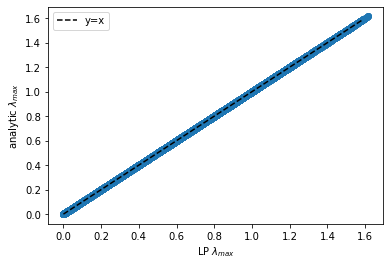

In [21]:
plt.scatter(res_df.lambda_hr.values, analytic_gammas)
xs = np.arange(0, 1.6, 0.01)
plt.plot(xs,xs, ls='--', color='k', label='y=x')
plt.legend()
plt.xlabel('LP $\lambda_{max}$')
plt.ylabel('analytic $\lambda_{max}$')
plt.show()

In [15]:
max_lambdas = np.linspace(0.01, 3, 50)
homeo_costs = np.logspace(1, 3, 3)
resp_costs = np.logspace(1, 3, 3)
ATP_per_es = [0.25, 0.5, 1, 2]

lmm = LinearMetabolicModel.FromFiles(m_fname, S_fname)
res_dict = dict(ZCB=[], phi_o=[], homeo_cost=[], lambda_max=[], S6=[], resp_cost=[], resp_ATP_per_e=[])

results = []

for max_lambda in max_lambdas:
    for homeo_cost in homeo_costs:
        for resp_cost in resp_costs:
            for atp_per_e in ATP_per_es:
                try:
                    ref_lam = lmm.copy()
                    ref_lam.set_process_mass('reduction', resp_cost)
                    ref_lam.set_process_mass('ATP_homeostasis', homeo_cost)
                    ref_lam.set_ATP_yield('reduction', atp_per_e)
                    m, opt_p = ref_lam.maximize_lambda(min_phi_o=0.4, max_lambda_hr=max_lambda)

                    d = ref_lam.model_as_dict()
                    d.update(ref_lam.solution_as_dict(opt_p))
                    d['reduction_ATP_per_e'] = atp_per_e
                    results.append(d)
                except:
                    continue
res_df2 = pd.DataFrame(results)

/opt/miniconda3/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:178: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


/var/folders/h9/fvnb4xnn63qg71jx6ncvg62w0000gn/T/ipykernel_44683/1916662547.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.axvline(res_df[mask].lambda_hr.max(), color='k', linestyle='--', label='$\lambda_{max}$')


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

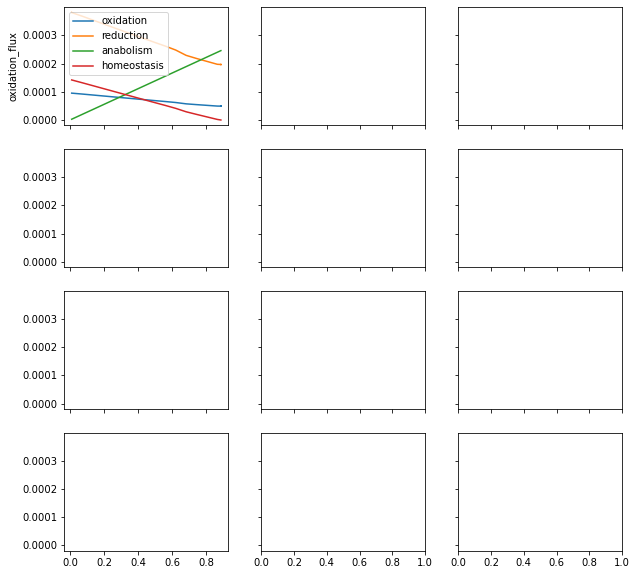

In [16]:
fig, axs = plt.subplots(figsize=(10, 10), nrows=4, ncols=3, sharex='col', sharey=True)

titles = '10% reduction cost,uniform costs,10x reduction cost'.split(',')
for i, a_per_e in enumerate(ATP_per_es):
    for j, resp_cost in enumerate(resp_costs):
        plt.sca(axs[i, j])
        mask = np.logical_and(res_df2.reduction_m_kDa == resp_cost, res_df2.reduction_ATP_per_e == a_per_e)
        mask = np.logical_and(mask, res_df2.ATP_homeostasis_m_kDa == 100)
        sns.lineplot(data=res_df2[mask], x='lambda_hr', y='oxidation_flux', palette='dark', label='oxidation')
        sns.lineplot(data=res_df2[mask], x='lambda_hr', y='reduction_flux', palette='dark', label='reduction')
        sns.lineplot(data=res_df2[mask], x='lambda_hr', y='anabolism_flux', palette='dark', label='anabolism')
        sns.lineplot(data=res_df2[mask], x='lambda_hr', y='ATP_homeostasis_flux', palette='dark', label='homeostasis')
        plt.axvline(res_df[mask].lambda_hr.max(), color='k', linestyle='--', label='$\lambda_{max}$')        
        plt.legend().set_visible(False)

        if i == 0:
            plt.title(titles[j])
        
        if j == 0:
            plt.ylabel(r'flux, {0} ATP/e-'.format(a_per_e))
        if i == 3:
            plt.xlabel(r'growth rate $\lambda$ (hr$^{-1}$)')

plt.sca(axs[0,2])
plt.legend(title='flux (rate/cell mass)').set_visible(True)

plt.tight_layout()
plt.savefig('../output/lambda_v_flux_sweep.png', dpi=300, facecolor='white')
plt.show()

<AxesSubplot: xlabel='reduction_m_kDa', ylabel='lambda_hr'>

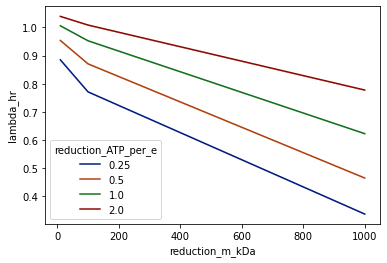

In [ ]:
max_idx = res_df2.groupby('reduction_m_kDa,ATP_homeostasis_m_kDa,reduction_ATP_per_e'.split(',')).lambda_hr.idxmax()
max_lambda = res_df2.loc[max_idx]

sns.lineplot(data=max_lambda, x='reduction_m_kDa', y='lambda_hr', hue='reduction_ATP_per_e', palette='dark')